# Redes Neurais - Previsão de Série Temporal: Valor do Bitcoin

| Hiperparâmetro específicos da LSTM | O que controla?                   | Valores típicos  |
| -------------- | --------------------------------- | ---------------- |
| `hidden_dim`   | Tamanho do vetor de estado oculto | 32, 64, 128, 256 |
| `layer_dim`    | Nº de camadas LSTM empilhadas     | 1, 2, às vezes 3 |
| `seq_length`   | Tamanho da janela de tempo usada para prever a próximo valor |  |

## Importa Bibliotecas e Prepara Device

In [115]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Carregamento e Visualização dos Dados

In [117]:
df = pd.read_csv('data_bitcoin.csv')

In [118]:
df.head()

,date,open,high,low,close,number_of_trades
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,3427
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,5233
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,2153
3,2017-08-20,4139.98,4211.08,4032.62,4086.29,2321
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,3972


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


In [120]:
df.describe()

,open,high,low,close,number_of_trades
count,2176.000000,2176.000000,2176.000000,2176.000000,2.176000e+03
mean,20074.277578,20613.574283,19468.753051,20085.572486,1.462627e+06
std,16058.230026,16490.568746,15560.344106,16055.913598,2.057254e+06
min,3188.010000,3276.500000,2817.000000,3189.020000,2.153000e+03
25%,7627.735000,7829.747500,7424.250000,7628.355000,2.803172e+05
50%,11705.580000,11933.360000,11334.110000,11728.035000,7.407820e+05
75%,29866.525000,30423.460000,29224.382500,29866.532500,1.595982e+06
max,67525.820000,69000.000000,66222.400000,67525.830000,1.522359e+07


In [121]:
df_close = df['close']

In [122]:
df_close.head()

0    4285.08
1    4108.37
2    4139.98
3    4086.29
4    4016.00
Name: close, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


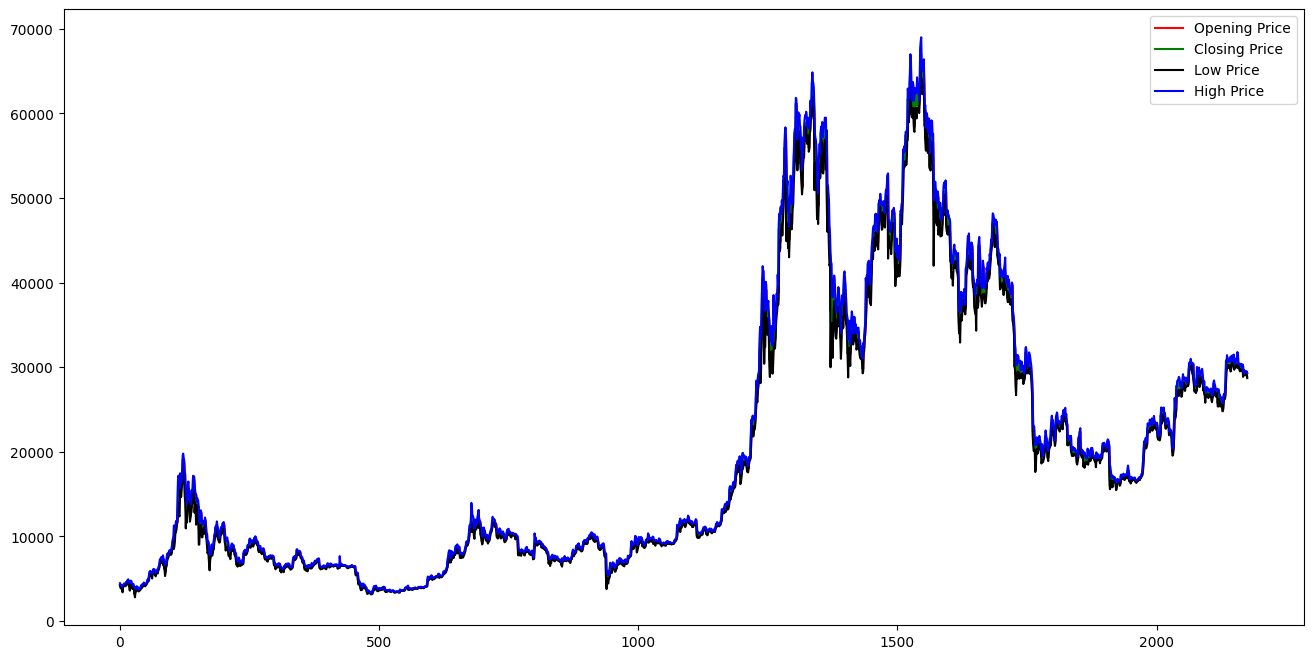

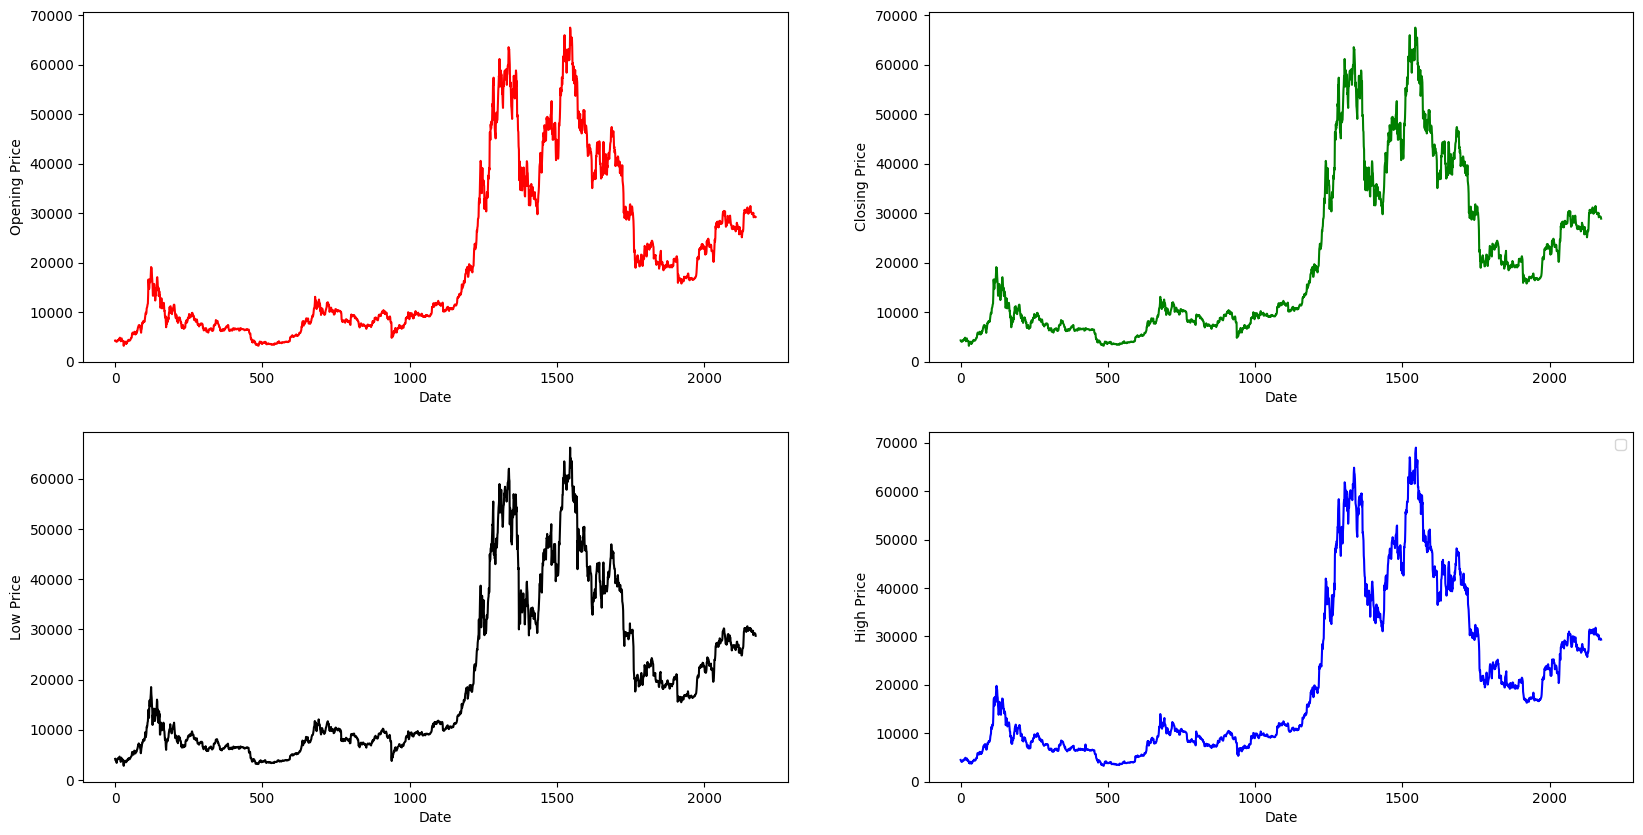

In [123]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(df['open'], color='red', label = 'Opening Price')
plt.plot(df['close'], color='green', label = 'Closing Price')
plt.plot(df['low'], color='black', label = 'Low Price')
plt.plot(df['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(df['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(df['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(df['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(df['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

## Definição do Modelo e Treinamento

In [124]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [125]:
def train_lstm(model, criterion, optimizer, num_epochs, trainX, trainY):
    h0, c0 = None, None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs, h0, c0 = model(trainX, h0, c0)

        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        h0 = h0.detach()
        c0 = c0.detach()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [126]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

## Função para Previsão Multi-Step

Cria um loop em que cada iteração usa a lstm para fazer a previsão um passo a frente. Na primeira iteração faz a previsão baseado em seq_length valores reais, na segunda usa o seq_length - 1 valores reais e o último valor previsto e assim por diante:
* Faz uma previsão 1 passo à frente
* Cria uma noava janela em que remove o primeiro valor a adiciona a nova previsão

In [127]:
def forecast_n_steps(model, last_window, n_steps, input_dim):
    """
    model: modelo LSTM treinado
    last_window: tensor (1, seq_length, input_dim) -> última janela real
    n_steps: quantos passos você quer prever
    input_dim: número de features (1 se for univariado)
    """
    model.eval()
    preds = []
    window = last_window.clone()

    with torch.no_grad():
        h0, c0 = None, None

        for _ in range(n_steps):
            # Faz uma previsão 1 passo à frente
            y_pred, h0, c0 = model(window, h0, c0)

            # Guarda a previsão
            preds.append(y_pred.item())

            # Cria novo input com a previsão
            new_input = y_pred.view(1, 1, input_dim)

            # Remove o primeiro valor da janela e adiciona o novo
            window = torch.cat([window[:, 1:, :], new_input], dim=1)

            # Para estabilidade: detach dos hidden states
            h0 = h0.detach()
            c0 = c0.detach()

    return preds


## Funções Auxiliares

In [128]:
import numpy as np

def inverse_transform_single_column(y_pred, scaler, num_feat, col_idx=0):
    """
    Desfaz a normalização de uma previsão de 1 coluna,
    usando o scaler que espera todas as features.

    Parâmetros:
    ----------
    y_pred : torch.Tensor ou np.ndarray
        Previsões normalizadas (shape: [N, 1] ou [N])
    scaler : sklearn MinMaxScaler
        O scaler já ajustado nos dados originais.
    num_feat : int
        Número total de features que o scaler espera.
    col_idx : int
        Índice da coluna onde a previsão estava (default: 0)

    Retorna:
    -------
    y_pred_denorm : np.ndarray
        Previsões desnormalizadas (shape: [N, 1])
    """

    # Se for tensor, converte pra numpy
    if hasattr(y_pred, 'cpu'):
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_pred_np = np.asarray(y_pred)

    # Garante forma correta
    y_pred_np = y_pred_np.squeeze()

    if y_pred_np.ndim == 0:
        y_pred_np = np.expand_dims(y_pred_np, 0)

    N = y_pred_np.shape[0]

    # Cria vetor fake com todas features
    y_pred_full = np.zeros((N, num_feat))
    y_pred_full[:, col_idx] = y_pred_np

    # Faz inverse transform
    y_pred_denorm_full = scaler.inverse_transform(y_pred_full)

    # Pega só a coluna de interesse
    y_pred_denorm = y_pred_denorm_full[:, col_idx].reshape(-1, 1)

    return y_pred_denorm

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lstm_forecast(y_pred, X_raw, X_test, seq_length, label='Value'):
    """
    Plota previsões do modelo LSTM junto com os dados originais e a série combinada.

    Parâmetros:
    -----------
    y_pred_test : torch.Tensor
        Previsões do modelo em tensor.
    X_raw : numpy.ndarray
        Série original (não escalada).
    X_test : torch.Tensor
        Conjunto de teste em formato sequencial.
    seq_length : int
        Comprimento da janela de entrada usada na LSTM.
    label : str
        Nome do eixo Y (default: 'Value').
    """

    # Cria vetor de tempo para o trecho previsto
    original = X_raw[-len(y_pred):]
    time_pred = np.arange(len(X_raw) - len(y_pred), len(X_raw))

    # Reconstrói a série combinada
    look_back = seq_length
    train_end_idx = len(X_raw) - len(X_test) - look_back + 1

    real_part = X_raw[:train_end_idx].squeeze()
    forecast_part = y_pred.squeeze()

    combined = np.concatenate((real_part, forecast_part))
    time_combined = np.arange(len(combined))

    # Cria figura com subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Previsão local vs real
    axs[0].plot(time_pred, original, label='Original Data')
    axs[0].plot(time_pred, y_pred.squeeze(), label='Predicted Data', linestyle='--')
    axs[0].set_title('LSTM Predictions vs. Original Data')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel(label)
    axs[0].legend()

    # Subplot 2: Série combinada completa
    axs[1].plot(time_combined, combined, label='Combined Real + Predicted', linestyle='-')
    axs[1].axvline(x=len(real_part)-1, color='r', linestyle='--', label='Start of Prediction')
    axs[1].set_title('Full Series with Forecast Appended')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel(label)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return combined


## Separação dos dados

Separação dos dados:
* 80% dos dados foram separados para o treinamento e 20% ficam reservados para o teste.

* X_all_train e X_all_test têm 5 features e são utilizados como conjuntos de treinamento e teste na abordagem 2. 

* X_close_train e X_close_test apresentam apenas a feature `close` e são utilizados na abordagem 1.

Obs. é importante utilizar fit_transform apenas no conjunto de treinamento para evitar data leakege, caso o scaler seja treinado no conjunto inteiro. estatísticas de dados futuros iriam influenciar a normalização dos outros dados.

In [ ]:
# remove coluna date -> fica apenas com features numéricas
df_raw = df.drop('date', axis=1)
X_raw = df_raw.values

# separa treino e teste
train_size = int(len(X_raw) * 0.8)
X_train_raw = X_raw[:train_size]
X_test_raw = X_raw[train_size:]

# normaliza dados
scaler = MinMaxScaler(feature_range=(0, 1))
X_all_train = scaler.fit_transform(X_train_raw)
X_all_test = scaler.transform(X_test_raw)

# transforma em tensor e coloca na gpu (se disponível)
X_all_train = torch.tensor(X_all_train, dtype=torch.float32).to(device)
X_all_test = torch.tensor(X_all_test, dtype=torch.float32).to(device)

# cria numpy arrays apenas com a série do close -> penúltima coluna
X_close_train = X_all_train[:, -2].unsqueeze(1)  # agora (N, 1)  
X_close_test = X_all_test[:, -2].unsqueeze(1)  # agora (N, 1) 

print(X_all_train.shape)
print(X_all_test.shape)

print(X_close_train.shape)
print(X_close_test.shape)

torch.Size([1740, 5])
torch.Size([436, 5])
torch.Size([1740, 1])
torch.Size([436, 1])


## Abordagem 1: Apenas os valores de fechamento

In [131]:
# Hiperparâmetros
seq_length = 10
num_epochs = 100
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01


In [132]:

# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_test.shape)

torch.Size([1730, 10, 1])
torch.Size([426, 10, 1])


In [133]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [134]:
train_lstm(model, criterion, optimizer, num_epochs, X_train, Y_train)

Epoch [10/100], Loss: 0.0600
Epoch [20/100], Loss: 0.0282
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0005


Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004


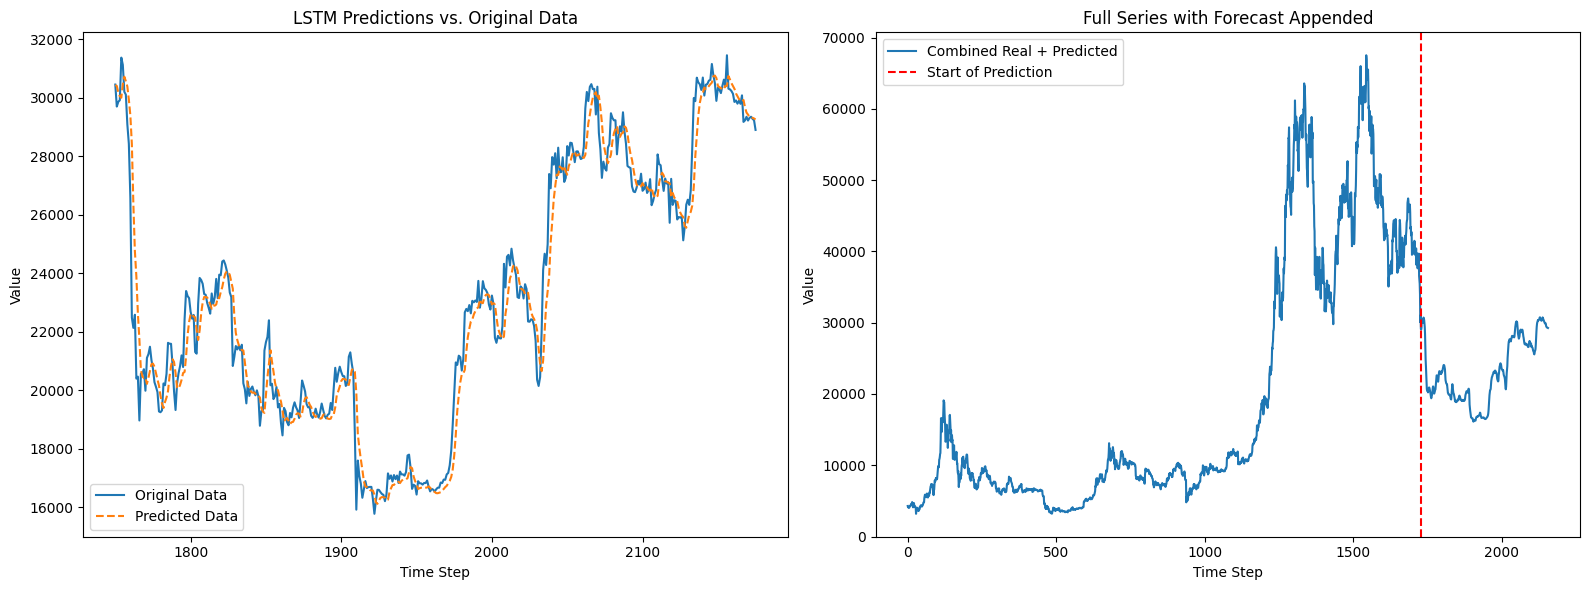

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29315.95734864, 29293.32992059, 29258.77424664])

In [135]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [136]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1 
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

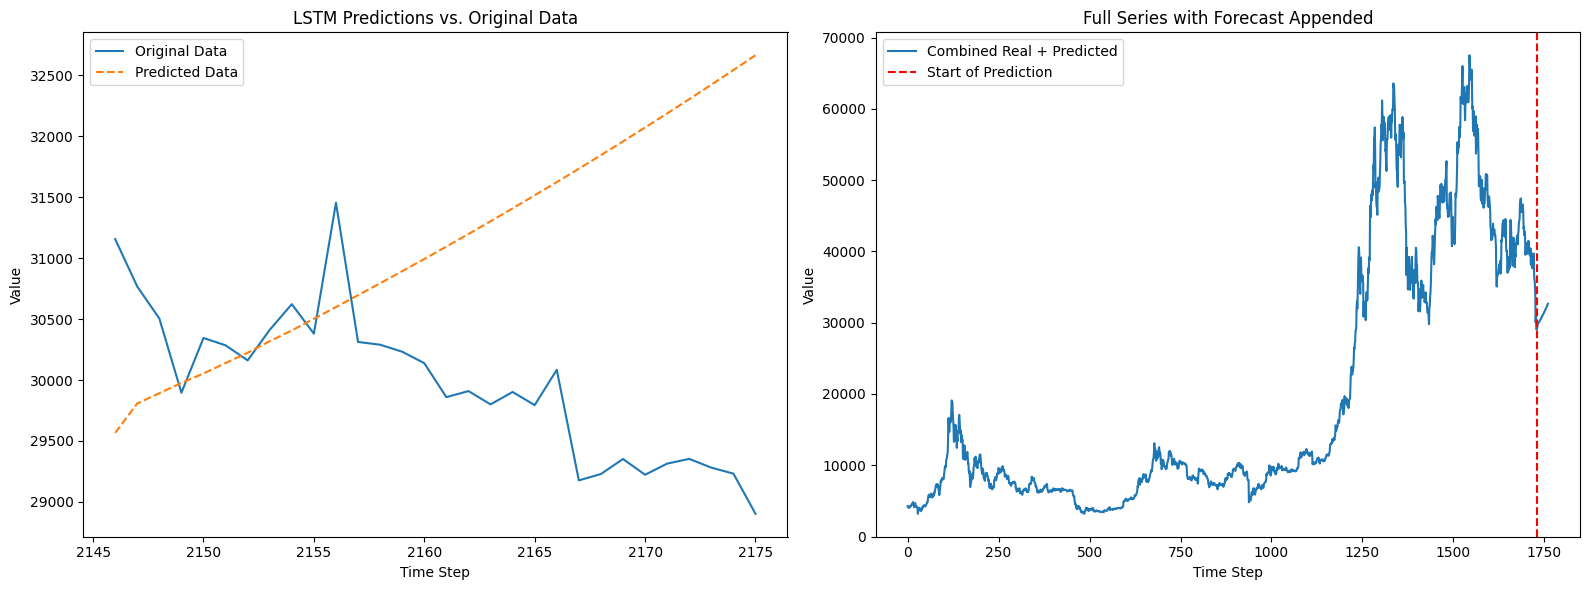

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       32422.47063721, 32542.43186155, 32663.87524859])

In [137]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Abordagem 2: Usando Todas as Features

In [138]:
# Hiperparâmetros
seq_length = 10
num_epochs = 100
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
num_feat = 5

In [143]:
# cria sequências
X_train, _ = create_sequences(X_all_train, seq_length)
X_test, _ = create_sequences(X_all_test, seq_length)

_, Y_train = create_sequences(X_close_train, seq_length)
_, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(Y_train.shape)

torch.Size([1730, 10, 5])
torch.Size([1730, 1])


In [144]:
model = LSTMModel(input_dim=num_feat, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [145]:
train_lstm(model, criterion, optimizer, num_epochs, X_train, Y_train)

Epoch [10/100], Loss: 0.0032
Epoch [20/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0007
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004


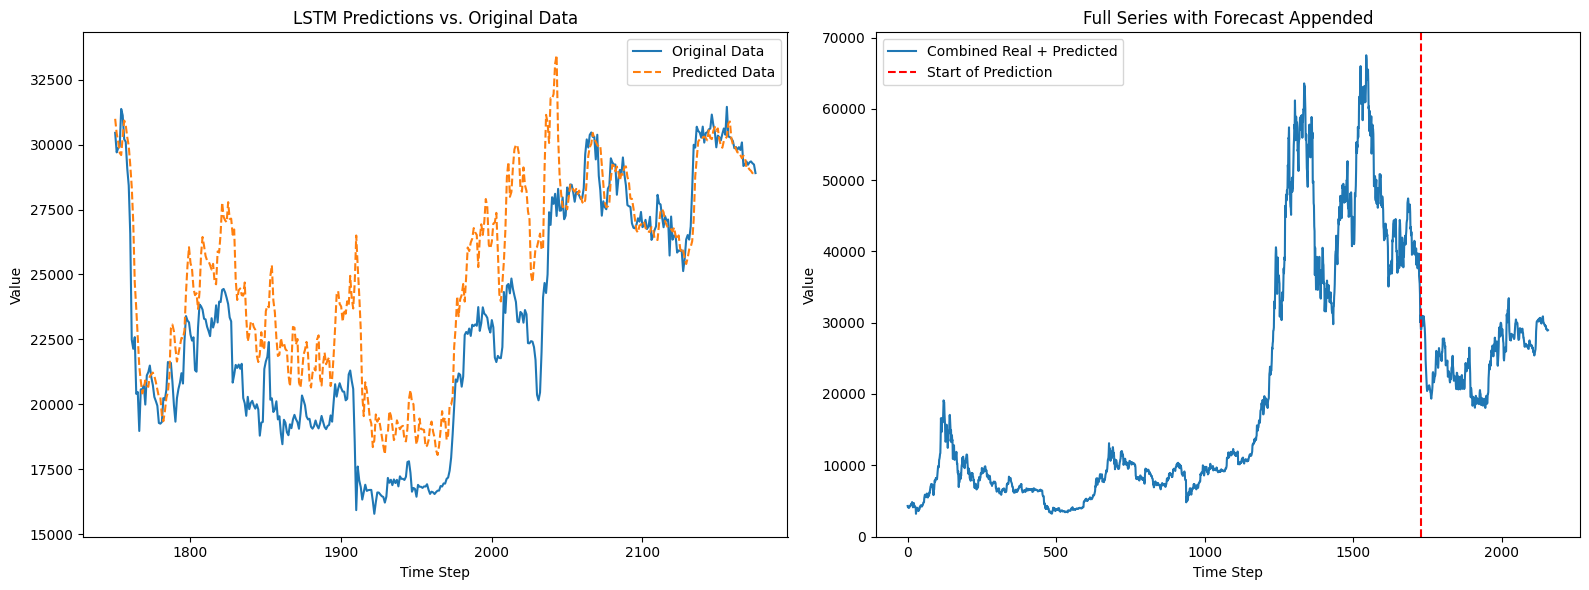

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       28900.34014023, 28905.12984578, 28954.66437474])

In [146]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)